<a href="https://colab.research.google.com/github/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project2-PhysicsML/lib/Lake_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Lake Thermal Stratification

In this notebook, we reproduce physics-guided deep learning models proposed in Read *et al* (2019) and Jia *et al* (2019). We use only the Lake Mendota data in this notebook. 

Both papers combine state-of-the-art deep learning models with strategies to incorporaate "guidance" from known physics that governs the dynamics of lake thermal stratefication. 

This notebook provides a set of starter codes for [LEAP CPC Spring 2022](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges)[Project 2](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/tree/main/Project-StarterCodes/Project2-PhysicsML) on

+ how to download data,
+ how to set up physics-guided loss functions,
+ how to setup deep learning models using PyTorch,
+ how to pre-train and re-train DL models, with early stopping,
+ how to evaluate and visualize model predictions.

All the codes in this notebook can be modified to implement research ideas. 

To start, the **team leader** of each team should 
+ create in the course folder a folder for project 2.
This folder can be used to share notes, data, outputs and codes. See [project 2 description](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Project-StarterCodes/Project2-PhysicsML/doc/project2_desc.md) for a suggested set up. 
+ share project 2 folder with all team members.
+ team members should add this folder to their drive by creating a shortcut to this shared project folder in their own folder for LEAP CPC.
+ go to "File/Save A Copy in Drive/" (upper left) and save a copy for your team in the project 2 folder that was just created, under an appropriate subfolder. 
+ for collaboration, team members should all add a shortcut of their project 2 folder to the folder "Colab Notebooks" in the root of your Google Drive. See below for more instructions. 


# Part 0. Setup Workspace

## Import packages and adjust settings

In [4]:
%%capture
!pip3 install sciencebasepy

In [5]:
import os, random, warnings
import numpy as np
import pandas as pd
import datetime
import torch
import cv2
import re
import matplotlib.pyplot as plt
import sciencebasepy
import urllib.request
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
from sklearn import preprocessing
from urllib.request import urlopen
from zipfile import ZipFile

For this project, it is important for the team to set up a shared Google Drive to collaborate using the same notebook, while saving intermediate outputs and results to the shared folder. Therefore

In [6]:
# mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


For this project, we will be using PyTorch, which will benefit tremendously from acceleration by GPU. Make sure that you are on a GPU run time. This notebook runs sufficiently fast without a [Google Colab Pro](https://colab.research.google.com/signup) subscription. However, teams with ambitious plans may need more memory and more computational power offer by a Pro subscription. The Pro subscription is not available to LionMail. You would need to share your project with a personal gmail account to enable the Pro subscription. 

In [7]:
# check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Set Data Directory and Shared Folder

Each team should create a shortcut to your project folder in the "Colab Notebooks" folder similar to "LEAP Colab Notebooks/Project 2/." There should be a folder for raw data and a folder for outputs. 

**data_dir** should be set as 'drive/Mydrive/Colab Notebooks/SHARED_FOLDER/Data/', where SHARED_FOLDER is the name of the shared folder.

In [8]:
# need to add shortcut of the shared folder to folder "/MyDrive/Colab Notebooks/"
# and change the folder name accordingly
data_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Data/'
output_dir = 'drive/MyDrive/Colab Notebooks/LEAP Colab Notebooks/Project 2/Output/'
if not os.path.isdir(data_dir): os.mkdir(data_dir) ## create the folder
if not os.path.isdir(output_dir): os.mkdir(output_dir) ## create the folder

## Download and Unzip Data

This block will only download the data to the shared Google Drive Folder once. By having a designated folder for raw data, you can always delete every files from the folder and re-download all data to start over, in the case some files are overwritten inadvertently. 

In [9]:
if os.listdir(data_dir) == []: ## data not downloaded yet
    print('Data folder is empty! Download the files now!')
    # set the url
    zipurl = 'https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/raw/main/Project-StarterCodes/Project2-PhysicsML/data/numpy_files.zip'
    # download the file from the URL
    zipresp = urlopen(zipurl)
    # create a new file on the hard drive
    tempzip = open(data_dir + 'numpy_files.zip', "wb")
    # write the contents of the downloaded file into the new file
    tempzip.write(zipresp.read())
    # close the newly-created file
    tempzip.close()
    # re-open the newly-created file with ZipFile()
    zf = ZipFile(data_dir + 'numpy_files.zip')
    # extract its contents into <extraction_path>
    # note that extractall will automatically create the path
    zf.extractall(path = data_dir)
    # close the ZipFile instance
    zf.close()
    print('Files all downloaded!')

# Part I. Model Pre-training

[Data](https://www.sciencebase.gov/catalog/item/5d88ea50e4b0c4f70d0ab3c0) and [original codes](https://zenodo.org/record/3497495#.YgB85_XMIqv) of Read et al (2019) are all publicly available, which makes this reproducibility effort reasonably easy. 

Read et al (2019) and Jia et al (2019) proposed a [Long short-term memory (LSTM)](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) network for modeling temperature dynamics. The original codes used TensorFlow version 1.0. In this notebook, we adopt this model using [PyTorch](https://pytorch.org/), an open-source ML framework with excellent libraries for deep learning.  

As proposed in the papers, physics guidance were introduced in two ways. The first is adding an energy conservation term to the loss funcation. The second is pretraining the LSTM networks using simulation data from the [General Lake Model](https://aed.see.uwa.edu.au/research/models/glm/). 

In the following, we outline
+ Algorithm configering constants
+ Set up functions for calculating energy conservation
+ Load the data
+ Setup the LSTM model
+ Train the LSTM model using simulated data

## Constants
We set the algorithm configuring constants in this part.

In [10]:
# params for LSTM
epochs = 300 ## number of max training epochs
batch_size = 100 ## batch size in SGD, must be multiplication of n_depths
learning_rate = 1e-2 ## learning rate 
state_size = 7 ## dimension of hidden layers 
input_size = 9 ## matches with the data, last dimension of x
phy_size = 10 ## matches with the data, last dimension of phy
elam = 0.005 ## loss weight
patience = 3 ## patience in early stopping


# params for data transformation
npic = 10 #16 #40 stride size
N_sec = (npic-1)*2+1 ## window width
n_depths = 50 ## matches with data, first dimension of x, also = len(depth_areas)
ec_threshold = 24
depth_areas = torch.Tensor([
        39865825,38308175,38308175,35178625,35178625,33403850,31530150,31530150,30154150,30154150,29022000,
        29022000,28063625,28063625,27501875,26744500,26744500,26084050,26084050,25310550,24685650,24685650,
        23789125,23789125,22829450,22829450,21563875,21563875,20081675,18989925,18989925,17240525,17240525,
        15659325,14100275,14100275,12271400,12271400,9962525,9962525,7777250,7777250,5956775,4039800,4039800,
        2560125,2560125,820925,820925,216125]).to(device)


## Function definitions for calculating ec loss

In [11]:
def transformTempToDensity(temp):
    # converts temperature to density
    # parameter:
        # @temp: single value or array of temperatures to be transformed
    densities = 1000 * (1 - ((temp + 288.9414) * (temp - 3.9863)**2) / (508929.2 * (temp + 68.12963)))
    return densities

def calculate_lake_energy(temps, densities, depth_areas):
    # calculate the total energy of the lake for every timestep
    # sum over all layers the (depth cross-sectional area)*temp*density*layer_height)
    # then multiply by the specific heat of water 
    dz = 0.5 # thickness for each layer, hardcoded for now
    cw = 4186 # specific heat of water
    depth_areas = torch.reshape(depth_areas, (-1, 1))
    energy = torch.sum(depth_areas * temps * densities * dz * cw, axis=0)
    return energy

def calculate_lake_energy_deltas(energies, combine_days, surface_area):
    # given a time series of energies, compute and return the differences
    # between each time step, or time step interval (parameter @combine_days)
    # as specified by parameter @combine_days
    time = 86400 #seconds per day
    energy_deltas = (energies[1:] - energies[:-1]) / (time * surface_area)
    return energy_deltas

def calculate_vapour_pressure_saturated(temp):
    # returns in miilibars
    # Converted pow function to exp function workaround pytorch not having autograd implemented for pow
    exponent = (9.28603523 - (2332.37885 / (temp + 273.15))) * np.log(10)
    return torch.exp(exponent)

def calculate_vapour_pressure_air(rel_hum, temp):
    rh_scaling_factor = 1
    return rh_scaling_factor * (rel_hum / 100) * calculate_vapour_pressure_saturated(temp)


def calculate_wind_speed_10m(ws, ref_height = 2.):
    # from GLM code glm_surface.c
    c_z0 = torch.tensor(0.001) #default roughness
    return ws * (torch.log(10.0 / c_z0) / torch.log(ref_height / c_z0))

def calculate_air_density(air_temp, rh):
    # returns air density in kg / m^3
    # equation from page 13 GLM/GLEON paper(et al Hipsey)
    # Ratio of the molecular (or molar) weight of water to dry air
    mwrw2a = 18.016 / 28.966
    c_gas = 1.0e3 * 8.31436 / 28.966

    # atmospheric pressure
    p = 1013. #mb

    # water vapor pressure
    vapPressure = calculate_vapour_pressure_air(rh, air_temp)

    # water vapor mixing ratio (from GLM code glm_surface.c)
    r = mwrw2a * vapPressure / (p - vapPressure)
    return (1.0 / c_gas * (1 + r)/(1 + r / mwrw2a) * p / (air_temp + 273.15)) * 100

def calculate_heat_flux_sensible(surf_temp, air_temp, rel_hum, wind_speed):
    # equation 22 in GLM/GLEON paper(et al Hipsey)
    # GLM code ->  Q_sensibleheat = -CH * (rho_air * 1005.) * WindSp * (Lake[surfLayer].Temp - MetData.AirTemp);
    # calculate air density 
    rho_a = calculate_air_density(air_temp, rel_hum)

    # specific heat capacity of air in J/(kg*C)
    c_a = 1005.

    # bulk aerodynamic coefficient for sensible heat transfer
    c_H = 0.0013

    # wind speed at 10m
    U_10 = calculate_wind_speed_10m(wind_speed)
    return -rho_a * c_a * c_H * U_10 * (surf_temp - air_temp)

def calculate_heat_flux_latent(surf_temp, air_temp, rel_hum, wind_speed):
    # equation 23 in GLM/GLEON paper(et al Hipsey)
    # GLM code-> Q_latentheat = -CE * rho_air * Latent_Heat_Evap * (0.622/p_atm) * WindSp * (SatVap_surface - MetData.SatVapDef)
    # where,         SatVap_surface = saturated_vapour(Lake[surfLayer].Temp);
    #                rho_air = atm_density(p_atm*100.0,MetData.SatVapDef,MetData.AirTemp);
    # air density in kg/m^3
    rho_a = calculate_air_density(air_temp, rel_hum)

    # bulk aerodynamic coefficient for latent heat transfer
    c_E = 0.0013

    # latent heat of vaporization (J/kg)
    lambda_v = 2.453e6

    # wind speed at 10m height
    # U_10 = wind_speed
    U_10 = calculate_wind_speed_10m(wind_speed)
    # 
    # ratio of molecular weight of water to that of dry air
    omega = 0.622

    # air pressure in mb
    p = 1013.

    e_s = calculate_vapour_pressure_saturated(surf_temp)
    e_a = calculate_vapour_pressure_air(rel_hum, air_temp)
    return -rho_a * c_E * lambda_v * U_10 * (omega / p) * (e_s - e_a)

def calculate_energy_fluxes(phys, surf_temps, combine_days):    
    e_s = 0.985 # emissivity of water, given by Jordan
    alpha_sw = 0.07 # shortwave albedo, given by Jordan Read
    alpha_lw = 0.03 # longwave, albeda, given by Jordan Read
    sigma = 5.67e-8 # Stefan-Baltzmann constant
    R_sw_arr = phys[:-1,2] + (phys[1:,2] - phys[:-1,2]) / 2
    R_lw_arr = phys[:-1,3] + (phys[1:,3] - phys[:-1,3]) / 2
    R_lw_out_arr = e_s * sigma * (torch.pow(surf_temps[:] + 273.15, 4))
    R_lw_out_arr = R_lw_out_arr[:-1] + (R_lw_out_arr[1:] - R_lw_out_arr[:-1]) / 2

    air_temp = phys[:-1,4] 
    air_temp2 = phys[1:,4]
    rel_hum = phys[:-1,5]
    rel_hum2 = phys[1:,5]
    ws = phys[:-1, 6]
    ws2 = phys[1:,6]
    t_s = surf_temps[:-1]
    t_s2 = surf_temps[1:]
    E = calculate_heat_flux_latent(t_s, air_temp, rel_hum, ws)
    H = calculate_heat_flux_sensible(t_s, air_temp, rel_hum, ws)
    E2 = calculate_heat_flux_latent(t_s2, air_temp2, rel_hum2, ws2)
    H2 = calculate_heat_flux_sensible(t_s2, air_temp2, rel_hum2, ws2)
    E = (E + E2) / 2
    H = (H + H2) / 2
    fluxes = (R_sw_arr[:-1] * (1-alpha_sw) + R_lw_arr[:-1] * (1-alpha_lw) - R_lw_out_arr[:-1] + E[:-1] + H[:-1])
    return fluxes

def calculate_ec_loss(inputs, outputs, phys, depth_areas, n_depths, ec_threshold, combine_days=1):
    # description: calculates energy conservation loss
    # parameters: 
        # @inputs: features
        # @outputs: labels
        # @phys: features(not standardized) of sw_radiation, lw_radiation, etc
        # @ labels modeled temp (will not used in loss, only for test) !!! DO NOT MODIFY THIS LINE !!!
        # @depth_areas: cross-sectional area of each depth
        # @n_depths: number of depths
        # @use_gpu: gpu flag
        # @combine_days: how many days to look back to see if energy is conserved
    #*********************************************************************************
    n_sets = int(inputs.shape[0] / n_depths)
    densities = transformTempToDensity(outputs)
    diff_per_set_r = torch.empty(n_sets) 
    for i in range(n_sets):
        # loop through sets of n_depths
        # indices
        start_index = i * n_depths
        end_index = (i + 1) * n_depths
        # calculate lake energy for each timestep
        lake_energies = calculate_lake_energy(outputs[start_index:end_index, :], densities[start_index:end_index, :], depth_areas)
        # calculate energy change in each timestep
        lake_energy_deltas = calculate_lake_energy_deltas(lake_energies, combine_days, depth_areas[0])
        lake_energy_deltas = lake_energy_deltas[1:]
        # calculate sum of energy flux into or out of the lake at each timestep
        lake_energy_fluxes = calculate_energy_fluxes(phys[start_index, :, :], outputs[start_index, :], combine_days)
        ### can use this to plot energy delta and flux over time to see if they line up
        diff_vec = torch.abs(lake_energy_deltas - lake_energy_fluxes) 
        tmp_mask = 1 - phys[start_index+1, 1:-1, 9] 
        tmp_loss = torch.mean(diff_vec * tmp_mask)
        diff_per_set_r[i] = tmp_loss 
    diff_per_set = torch.clamp(diff_per_set_r - ec_threshold, min=0, max=999999)
    return torch.mean(diff_per_set), diff_vec, diff_per_set_r, diff_per_set 


## Load data

Here we load the data for pretraining and partition the data into training, validation and test sets. 

In [12]:
# load data
x_full = np.load(data_dir + '/processed_features.npy') #standardized inputs
x_raw_full = np.load(data_dir + '/features.npy') #raw inputs
diag_full = np.load(data_dir + '/diag.npy') 
label_full = np.load(data_dir + '/labels.npy') #simulated lake temperatures

# process data
mask_full = np.ones(label_full.shape) # no missing values to mask for simulated data
phy_full = np.concatenate((x_raw_full[:,:,:(-2)], diag_full), axis=2) 
## phy: 4-air temp, 5-rel hum, 6-wind speed, 9-ice flag

# print the shape
print(f"The shape of x_full is {np.shape(x_full)}")
print(f"The shape of x_raw_full is {np.shape(x_raw_full)}")
print(f"The shape of diag_full is {np.shape(diag_full)}")
print(f"The shape of label is {np.shape(label_full)}")

# train-val split
## in model pretraining, we use validation set to find the best number of steps 
## Here we use equal size for train-val split
## They can be of different sizes by using different n_steps 
N = np.shape(x_full)[1] # the total number of samples
idx_tr, idx_va, idx_te = (int(N/3), int(N/3*2), N)


## training
x_tr = x_full[:, :idx_tr]
y_tr = label_full[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask_full[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label_full[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask_full[:, idx_tr:idx_va]

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])


for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

# print the shape
print(f"The shape of x_train is {np.shape(x_train)}")
print(f"The shape of y_train is {np.shape(y_train)}")
print(f"The shape of p_train is {np.shape(p_train)}")
print(f"The shape of m_train is {np.shape(m_train)}")


The shape of x_full is (50, 12691, 9)
The shape of x_raw_full is (50, 12691, 9)
The shape of diag_full is (50, 12691, 3)
The shape of label is (50, 12691)
The shape of x_train is (950, 423, 9)
The shape of y_train is (950, 423)
The shape of p_train is (950, 423, 10)
The shape of m_train is (950, 423)


## Class definition of LSTM model
We set up a relatively standard LSTM network. See [the PyTorch tutorial on LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for details. 

In [13]:
class LSTMnet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTMnet, self).__init__()
        self.output_size = output_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = n_layers, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = out.view(batch_size, -1)
        return out

## Function definitions for Deep Learning

In the training, the loss funcation is a weighted sum of the *prediction error* loss and *energy conservation* loss. The algorithm processes a mini batch of data at a time and use backpropagation to update model parameters. The training intends to run the specified number of epochs but will stop *early* if the returned loss increases for three consequential updates. 

In [14]:
def weighted_rmse_loss(input, target, weight):
    # defined weighted rmse loss
    # used in model training
    return torch.sqrt(torch.sum(weight * (input - target) ** 2) / torch.sum(weight))

def batch_sample_generator(size_list, batch_size):
    ## create advanced batches for training-val-test
    ## each batch should match with depth_areas for calculating ec_loss
    n_batch = int(size_list / batch_size)
    n_remain = size_list % batch_size
    batch_sampler = [list(range(i * batch_size, i * batch_size + batch_size)) for i in range(n_batch)]
    if n_remain > 0:
        batch_sampler += [list(range(n_batch * batch_size, n_batch * batch_size + n_remain))]
    return batch_sampler


def train(model, epochs, optimizer, train_loader, valid_loader, early_stopping=True):
    the_last_loss = 100
    trigger_times = 0
    for i in range(epochs):
        print('This is epoch ' + str(i + 1))
        for batch, (x, y, m, p) in enumerate(train_loader):
            model.train()
            size = len(train_loader.dataset)
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)
            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas,
                                        n_depths,
                                        ec_threshold,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print output
            loss_track, current = loss.item(), batch * len(x)
            if batch%5 == 0:
                print("BatLoss = " + "{:.4f}".format(loss) + \
                    ", Rc = " + "{:.4f}".format(loss_1) + \
                    ", Ec = " + "{:.4f}".format(loss_2) + \
                    f'[{current:>5d}/{size:>5d}]')
        
        # Early stopping
        if early_stopping:
            the_current_loss = val_test(model, valid_loader)
            print('The current loss:', the_current_loss)
            if the_current_loss > the_last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping!\nStart to test process.')
                    return model, (i+1)
            else:
                trigger_times = 0 ## reset trigger time to 0
                the_last_loss = the_current_loss

    return model, epochs
        

def val_test(model, data_loader):
    # Settings
    model.eval()

    loss_total = 0
    # make predictions on validation/test data
    with torch.no_grad():
        for batch, (x, y, m, p) in enumerate(data_loader):
            x = x.to(device).float()
            y = y.to(device)
            m = m.to(device)
            p = p.to(device)

            # Compute prediction and loss
            pred = model(x)
            loss_1 = weighted_rmse_loss(pred, y, m)
            loss_2, a, b, c = calculate_ec_loss(x,
                                        pred,
                                        p,                                     
                                        depth_areas,
                                        n_depths,
                                        ec_threshold,
                                        combine_days=1)
            loss = loss_1 + elam * loss_2
            loss_total += loss.item()
    return loss_total / len(data_loader)



## Create data loaders

In [15]:
train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

## Training with early-stopping

Here we train the model with early stopping. That is, if the model 

In [16]:
# train the model with early stopping
## initialize model
net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, best_epoch = train(net, epochs, optimizer, tr_loader, va_loader)

This is epoch 1
BatLoss = 11.2963, Rc = 10.1567, Ec = 227.9222[    0/  950]
BatLoss = 11.5455, Rc = 10.4007, Ec = 228.9714[  500/  950]
The current loss: 11.245773403734882
This is epoch 2
BatLoss = 10.8612, Rc = 9.7458, Ec = 223.0675[    0/  950]
BatLoss = 10.9723, Rc = 9.8603, Ec = 222.3923[  500/  950]
The current loss: 10.528699237325462
This is epoch 3
BatLoss = 10.1454, Rc = 9.0557, Ec = 217.9277[    0/  950]
BatLoss = 10.1994, Rc = 9.1269, Ec = 214.4844[  500/  950]
The current loss: 9.74712720419046
This is epoch 4
BatLoss = 9.3406, Rc = 8.2826, Ec = 211.6186[    0/  950]
BatLoss = 9.4235, Rc = 8.3880, Ec = 207.0916[  500/  950]
The current loss: 8.893480282794403
This is epoch 5
BatLoss = 8.4845, Rc = 7.4803, Ec = 200.8374[    0/  950]
BatLoss = 8.5243, Rc = 7.5584, Ec = 193.1699[  500/  950]
The current loss: 8.082442582936993
This is epoch 6
BatLoss = 7.6781, Rc = 6.7401, Ec = 187.5931[    0/  950]
BatLoss = 7.7553, Rc = 6.8617, Ec = 178.7142[  500/  950]
The current loss: 7

## Retrain with best parameters
During the training, the training segment and validation segment were used separately to identify the best epochs. Once a best set of paramemters are identified based on the loss evaluated using the validation set, the model should be retrained using the combined training and validation set to have the best estimation efficiency. 

In [17]:
# optional: retrain the model using the best #epochs over train+val
## initialize model
net = LSTMnet(input_dim = input_size, output_dim = 1, hidden_dim = state_size, n_layers = 1).to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, _ = train(net, best_epoch, optimizer, fu_loader, fu_loader, early_stopping=False)
## save the model

This is epoch 1
BatLoss = 11.5584, Rc = 10.4112, Ec = 229.4359[    0/ 1900]
BatLoss = 11.7983, Rc = 10.6462, Ec = 230.4039[  500/ 1900]
BatLoss = 10.3465, Rc = 9.2898, Ec = 211.3329[ 1000/ 1900]
BatLoss = 11.1775, Rc = 10.0589, Ec = 223.7161[ 1500/ 1900]
This is epoch 2
BatLoss = 10.4985, Rc = 9.4099, Ec = 217.7088[    0/ 1900]
BatLoss = 10.5561, Rc = 9.4723, Ec = 216.7681[  500/ 1900]
BatLoss = 8.9155, Rc = 7.9426, Ec = 194.5915[ 1000/ 1900]
BatLoss = 9.3859, Rc = 8.3762, Ec = 201.9262[ 1500/ 1900]
This is epoch 3
BatLoss = 8.6666, Rc = 7.6736, Ec = 198.5993[    0/ 1900]
BatLoss = 8.7686, Rc = 7.7891, Ec = 195.9043[  500/ 1900]
BatLoss = 7.4280, Rc = 6.5462, Ec = 176.3684[ 1000/ 1900]
BatLoss = 7.8757, Rc = 6.9647, Ec = 182.1928[ 1500/ 1900]
This is epoch 4
BatLoss = 7.3722, Rc = 6.4509, Ec = 184.2553[    0/ 1900]
BatLoss = 7.5063, Rc = 6.6134, Ec = 178.5730[  500/ 1900]
BatLoss = 6.3758, Rc = 5.5631, Ec = 162.5422[ 1000/ 1900]
BatLoss = 6.7132, Rc = 5.8753, Ec = 167.5727[ 1500/ 1900]

Save the trained model in the output folder for future use. 

In [18]:
torch.save(net, output_dir + 'model_pretrain.pt') ## save it in the output folder

# Part II.  PGRNN Training 

In this part, we *re-train* the model using observed data. The real data has missing observations, which will be *masked* in the loss calculation. 

## Load data

In [19]:
# load data ---------------------------------------------------------------
x_full = np.load(data_dir + 'processed_features.npy') # input data
x_raw_full = np.load(data_dir + 'features.npy') # raw input data
diag_full = np.load(data_dir + 'diag.npy')
label = np.load(data_dir + 'Obs_temp.npy') # real observation data
mask = np.load(data_dir + 'Obs_mask.npy') # flags of missing values
phy_full = np.concatenate((x_raw_full[:,:,:-2], diag_full), axis = 2) #physics variables

# train-val-test split
## Here we use equal size for train-val-test split
## They can be of different sizes by using different n_steps 
idx_tr, idx_va, idx_te = (4000, 8000, 12000)
print(idx_tr, idx_va, idx_te)

## training
x_tr = x_full[:, :idx_tr]
y_tr = label[:, :idx_tr]
p_tr = phy_full[:, :idx_tr]
m_tr = mask[:, :idx_tr]
## validation
x_va = x_full[:, idx_tr:idx_va]
y_va = label[:, idx_tr:idx_va]
p_va = phy_full[:, idx_tr:idx_va]
m_va = mask[:, idx_tr:idx_va]


## testing
x_te = x_full[:, idx_va:idx_te]
y_te = label[:, idx_va:idx_te]
p_te = phy_full[:, idx_va:idx_te]
m_te = mask[:, idx_va:idx_te]

# sparsify mask

s_perc =0.99 #0.002 #0.2#0.4 #0.6 #0.8
## training
m_tr = np.reshape(m_tr, (-1, 1))
loc_tr = np.random.choice(np.arange(m_tr.shape[0]), replace=False, size=int(m_tr.shape[0] * (1-s_perc)))
m_tr[loc_tr, 0] = 0.0
## validation
m_va = np.reshape(m_va, (-1, 1))
loc_va = np.random.choice(np.arange(m_va.shape[0]), replace=False, size=int(m_va.shape[0] * (1-s_perc)))
m_va[loc_va, 0] = 0.0
## reshaping
m_tr = np.reshape(m_tr, (50, -1))
m_va = np.reshape(m_va, (50, -1))

# create data
n_steps = int(idx_tr/npic)
x_train = np.zeros([n_depths * N_sec, n_steps, input_size])
y_train = np.zeros([n_depths * N_sec, n_steps])
p_train = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_train = np.zeros([n_depths * N_sec, n_steps])

x_val = np.zeros([n_depths * N_sec, n_steps, input_size])
y_val = np.zeros([n_depths * N_sec, n_steps])
p_val = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_val = np.zeros([n_depths * N_sec, n_steps])

x_test = np.zeros([n_depths * N_sec, n_steps, input_size])
y_test = np.zeros([n_depths * N_sec, n_steps])
p_test = np.zeros([n_depths * N_sec, n_steps, phy_size])
m_test = np.zeros([n_depths * N_sec, n_steps])

for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    x_train[(i-1)*n_depths:(i*n_depths)] = x_tr[:, r_1:r_2]
    y_train[(i-1)*n_depths:(i*n_depths)] = y_tr[:, r_1:r_2]
    p_train[(i-1)*n_depths:(i*n_depths)] = p_tr[:, r_1:r_2]
    m_train[(i-1)*n_depths:(i*n_depths)] = m_tr[:, r_1:r_2]
    x_val[(i-1)*n_depths:(i*n_depths)] = x_va[:, r_1:r_2]
    y_val[(i-1)*n_depths:(i*n_depths)] = y_va[:, r_1:r_2]
    p_val[(i-1)*n_depths:(i*n_depths)] = p_va[:, r_1:r_2]
    m_val[(i-1)*n_depths:(i*n_depths)] = m_va[:, r_1:r_2]
    x_test[(i-1)*n_depths:(i*n_depths)] = x_te[:, r_1:r_2]
    y_test[(i-1)*n_depths:(i*n_depths)] = y_te[:, r_1:r_2]
    p_test[(i-1)*n_depths:(i*n_depths)] = p_te[:, r_1:r_2]
    m_test[(i-1)*n_depths:(i*n_depths)] = m_te[:, r_1:r_2]

x_f = np.concatenate((x_train, x_val), axis=0)
y_f = np.concatenate((y_train, y_val), axis=0)
p_f = np.concatenate((p_train, p_val), axis=0)
m_f = np.concatenate((m_train, m_val), axis=0)

4000 8000 12000


## Create data loaders

In [20]:
train_data = TensorDataset(torch.from_numpy(x_train), 
                           torch.from_numpy(y_train), 
                           torch.from_numpy(m_train),
                           torch.from_numpy(p_train))

val_data = TensorDataset(torch.from_numpy(x_val), 
                         torch.from_numpy(y_val), 
                         torch.from_numpy(m_val),
                         torch.from_numpy(p_val))

test_data = TensorDataset(torch.from_numpy(x_test), 
                           torch.from_numpy(y_test), 
                           torch.from_numpy(m_test),
                           torch.from_numpy(p_test))

full_data = TensorDataset(torch.from_numpy(x_f), 
                          torch.from_numpy(y_f), 
                          torch.from_numpy(m_f),
                          torch.from_numpy(p_f))

tr_loader = DataLoader(train_data, batch_sampler=batch_sample_generator(len(train_data), batch_size))
va_loader = DataLoader(val_data, batch_sampler=batch_sample_generator(len(val_data), batch_size))
te_loader = DataLoader(test_data, batch_sampler=batch_sample_generator(len(test_data), batch_size))
fu_loader = DataLoader(full_data, batch_sampler=batch_sample_generator(len(full_data), batch_size))

## Training with early stopping

In [21]:
# train the model with early stopping
## initialize model
net = torch.load(output_dir + 'model_pretrain.pt').to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, best_epoch = train(net, epochs, optimizer, tr_loader, va_loader)

This is epoch 1
BatLoss = 3.2248, Rc = 3.1938, Ec = 6.2008[    0/  950]
BatLoss = 1.6117, Rc = 1.5062, Ec = 21.0838[  500/  950]
The current loss: 1.741180802536159
This is epoch 2
BatLoss = 1.9622, Rc = 1.8295, Ec = 26.5394[    0/  950]
BatLoss = 1.3531, Rc = 1.2428, Ec = 22.0519[  500/  950]
The current loss: 1.5428638006758564
This is epoch 3
BatLoss = 1.6182, Rc = 1.5324, Ec = 17.1558[    0/  950]
BatLoss = 1.2858, Rc = 1.1911, Ec = 18.9268[  500/  950]
The current loss: 1.424054761733425
This is epoch 4
BatLoss = 1.5675, Rc = 1.5017, Ec = 13.1495[    0/  950]
BatLoss = 1.2294, Rc = 1.1729, Ec = 11.3008[  500/  950]
The current loss: 1.433838014217607
This is epoch 5
BatLoss = 1.5143, Rc = 1.4594, Ec = 10.9644[    0/  950]
BatLoss = 1.1744, Rc = 1.1256, Ec = 9.7647[  500/  950]
The current loss: 1.4353361403790696
This is epoch 6
BatLoss = 1.4672, Rc = 1.4267, Ec = 8.1114[    0/  950]
BatLoss = 1.1762, Rc = 1.1313, Ec = 8.9671[  500/  950]
The current loss: 1.4042916749547893
This 

## Retrain with training + validation using best parameters

In [22]:
# optional: retrain the model using the best #epochs over train+val
## initialize model
net = torch.load(output_dir + 'model_pretrain.pt').to(device)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, _ = train(net, best_epoch, optimizer, fu_loader, fu_loader, early_stopping=False)
## save the model
torch.save(net, output_dir + 'model_finetune.pt') ## we save it in the data folder for simplicity, you can choose to save it in a different folder

This is epoch 1
BatLoss = 3.2248, Rc = 3.1938, Ec = 6.2008[    0/ 1900]
BatLoss = 1.6117, Rc = 1.5062, Ec = 21.0838[  500/ 1900]
BatLoss = 1.7743, Rc = 1.6572, Ec = 23.4201[ 1000/ 1900]
BatLoss = 1.4268, Rc = 1.3142, Ec = 22.5071[ 1500/ 1900]
This is epoch 2
BatLoss = 1.7758, Rc = 1.6938, Ec = 16.3833[    0/ 1900]
BatLoss = 1.3416, Rc = 1.2485, Ec = 18.6059[  500/ 1900]
BatLoss = 1.5127, Rc = 1.4269, Ec = 17.1616[ 1000/ 1900]
BatLoss = 1.2057, Rc = 1.1131, Ec = 18.5177[ 1500/ 1900]
This is epoch 3
BatLoss = 1.7302, Rc = 1.6646, Ec = 13.1176[    0/ 1900]
BatLoss = 1.2567, Rc = 1.2025, Ec = 10.8379[  500/ 1900]
BatLoss = 1.5517, Rc = 1.4864, Ec = 13.0614[ 1000/ 1900]
BatLoss = 1.2368, Rc = 1.1370, Ec = 19.9513[ 1500/ 1900]
This is epoch 4
BatLoss = 1.6970, Rc = 1.6371, Ec = 11.9929[    0/ 1900]
BatLoss = 1.2620, Rc = 1.2047, Ec = 11.4622[  500/ 1900]
BatLoss = 1.5553, Rc = 1.4807, Ec = 14.9229[ 1000/ 1900]
BatLoss = 1.2457, Rc = 1.1352, Ec = 22.1014[ 1500/ 1900]
This is epoch 5
BatLoss =

## Evaluation over test set

In [23]:
# evaluate the performance over test set
net = torch.load(output_dir + 'model_finetune.pt').to(device)
net.eval()
print('Test loss is:', val_test(net, te_loader))

Test loss is: 1.3718351454682318


In [24]:
# if there is no finetune
net = torch.load(output_dir + 'model_pretrain.pt').to(device)
net.eval()
print('Test loss is:', val_test(net, te_loader))

Test loss is: 2.3579796069253893


## Visualizations

In the following we create a few visualization of the data and model outputs to demonstrate the performance of the models. 

In [25]:
# load the dates information
dates_arr = np.load(data_dir + 'dates.npy')
dates_d = dates_arr.astype('M8[D]') ## transform the dates to date
dates_m = dates_arr.astype('M8[M]') ## transform the dates to date
dates_y = dates_arr.astype('M8[Y]') ## transform the dates to year
# load features
x_raw = np.load(data_dir + 'features.npy')
x_proc = np.load(data_dir + 'processed_features.npy')
# load the labels
label = np.load(data_dir + 'Obs_temp.npy')
print('Shape of labels:', label.shape)
# load the weight
weight = np.load(data_dir + 'Obs_mask.npy')
print('Shape of weight:', weight.shape)
print('Mean of weight:', np.mean(weight)) ## data is very sparse, 2% of the data are not nan
# filter the test set
label_test = label[:, idx_va:idx_te]
weight_test = weight[:, idx_va:idx_te]
dates_test_d = dates_d[idx_va:idx_te]
dates_test_m = dates_m[idx_va:idx_te]
dates_test_y = dates_y[idx_va:idx_te].astype(str)
print('Years available:', np.unique(dates_test_y))

Shape of labels: (50, 12691)
Shape of weight: (50, 12691)
Mean of weight: 0.020735954613505633
Years available: ['2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009' '2010' '2011'
 '2012' '2013']


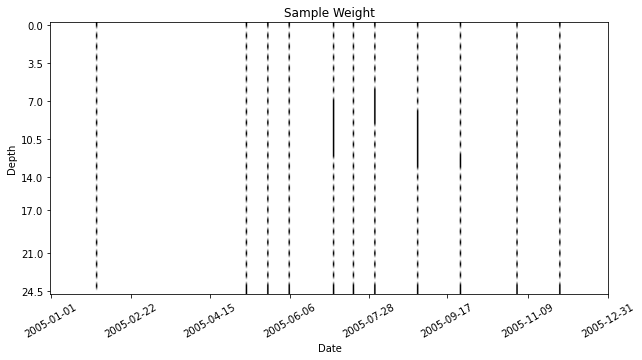

In [26]:
# visualize the weight
## black: data, white: zero-weight (NA value?)
year_choose = '2005'
idx = np.where(dates_test_y == year_choose)[0]
n_row = label_test.shape[0]
n_col = len(idx)
## make the figure
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(weight_test[:, idx] == 0, aspect='auto', cmap=plt.cm.gray)
x_choose = np.array(np.linspace(0, 1, 8) * (n_col-1), dtype=int)
ax.set_xticks(x_choose)
ax.set_xticklabels(dates_test_d[idx][x_choose], rotation=30, fontdict={'horizontalalignment': 'center'})
ax.set_xlabel('Date')
y_choose = np.array(np.linspace(0, 1, 8) * (n_row-1), dtype=int)
ax.set_yticks(y_choose)
ax.set_yticklabels(np.around(np.linspace(x_raw[0, 0, 1], x_raw[-1, -1, 1], n_row)[y_choose], decimals=1))
ax.set_ylabel('Depth')
ax.set_title('Sample Weight')
plt.show()

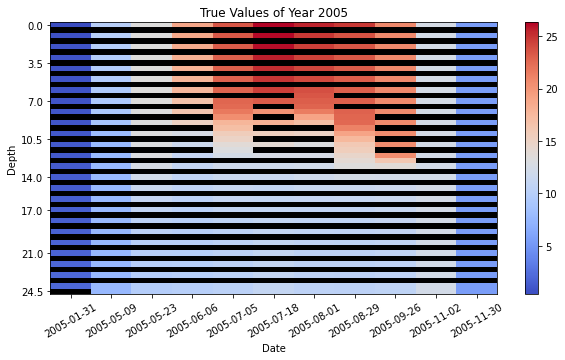

In [27]:
# visualize the true values
import matplotlib
weight_mat = weight_test[:, idx]
weight_sum = np.sum(weight_mat, axis=0)
idx_dt = np.where(weight_sum > 0)[0]
n_col = len(idx_dt)
label_mat = label_test[:, idx].copy()
label_mat[weight_test[:, idx] == 0] = np.nan
## make the figure
fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.cm.coolwarm
cmap.set_bad('black') ## we set the nan values to black, you can change it to other colors
im = ax.imshow(label_mat[:, idx_dt], aspect='auto', cmap=cmap)
ax.set_xticks(np.arange(n_col))
ax.set_xticklabels(dates_test_d[idx][idx_dt], rotation=30, fontdict={'horizontalalignment': 'center'})
ax.set_xlabel('Date')
y_choose = np.array(np.linspace(0, 1, 8) * (n_row-1), dtype=int)
ax.set_yticks(y_choose)
ax.set_yticklabels(np.around(np.linspace(x_raw[0, 0, 1], x_raw[-1, -1, 1], n_row)[y_choose], decimals=1))
ax.set_ylabel('Depth')
ax.set_title('True Values of Year ' + str(year_choose) )
fig.colorbar(im, ax=ax)
plt.show()

In [28]:
# visualize the predictions
net = torch.load(data_dir + 'model_finetune.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_mat = net(x).cpu().numpy()

label_pred = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_pred[:, r_1:r_2] = pred_mat[(i-1)*n_depths:(i*n_depths)].copy()

vis_mat = label_pred[:, idx].copy()
vis_mat[weight_test[:, idx] == 0] = np.nan
## make the figure
fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.cm.coolwarm
cmap.set_bad('black') ## we set the nan values to black, you can change it to other colors
im = ax.imshow(vis_mat[:, idx_dt], aspect='auto', cmap=cmap)
ax.set_xticks(np.arange(n_col))
ax.set_xticklabels(dates_test_d[idx][idx_dt], rotation=30, fontdict={'horizontalalignment': 'center'})
ax.set_xlabel('Date')
y_choose = np.array(np.linspace(0, 1, 8) * (n_row-1), dtype=int)
ax.set_yticks(y_choose)
ax.set_yticklabels(np.around(np.linspace(x_raw[0, 0, 1], x_raw[-1, -1, 1], n_row)[y_choose], decimals=1))
ax.set_ylabel('Depth')
ax.set_title('Predicted Values of Year ' + str(year_choose) )
fig.colorbar(im, ax=ax)
plt.show()

FileNotFoundError: ignored

In [ ]:
# visualize the residuals = true labels - predicted values
err_mat = label_test - label_pred
vis_mat = err_mat[:, idx].copy()
vis_mat[weight_test[:, idx] == 0] = np.nan
## make the figure
fig, ax = plt.subplots(figsize=(10, 5))
cmap = matplotlib.cm.coolwarm
cmap.set_bad('black') ## we set the nan values to black, you can change it to other colors
im = ax.imshow(vis_mat[:, idx_dt], aspect='auto', cmap=cmap)
ax.set_xticks(np.arange(n_col))
ax.set_xticklabels(dates_test_d[idx][idx_dt], rotation=30, fontdict={'horizontalalignment': 'center'})
ax.set_xlabel('Date')
y_choose = np.array(np.linspace(0, 1, 8) * (n_row-1), dtype=int)
ax.set_yticks(y_choose)
ax.set_yticklabels(np.around(np.linspace(x_raw[0, 0, 1], x_raw[-1, -1, 1], n_row)[y_choose], decimals=1))
ax.set_ylabel('Depth')
ax.set_title('Residuals of Year ' + str(year_choose) )
fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
# Part II. visualizations for comparing pretrained model and fine-tuned model
net = torch.load(data_dir + 'model_pretrain.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_pret = net(x).cpu().numpy()

label_pret = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_pret[:, r_1:r_2] = pred_pret[(i-1)*n_depths:(i*n_depths)].copy()
err_pret = label_test - label_pret

net = torch.load(data_dir + 'model_finetune.pt').to(device)
net.eval()
with torch.no_grad():
    x = torch.from_numpy(x_test).to(device).float()
    pred_fine = net(x).cpu().numpy()

label_fine = np.zeros(label_test.shape)
for i in range(1, N_sec + 1):
    r_1 = int((i - 1) * n_steps / 2) ## stride size = n_steps / 2
    r_2 = r_1 + n_steps ## step size = n_step
    label_fine[:, r_1:r_2] = pred_fine[(i-1)*n_depths:(i*n_depths)].copy()
err_fine = label_test - label_fine

In [ ]:
# visualizatin along different months
## keep the month information and transform to int
dates_test_m_int = np.array([str(i)[-2:] for i in dates_test_m]).astype(int)
RMSE_pret = []
RMSE_fine = []
for i in range(1, 13):
    weight_m = weight_test[:, dates_test_m_int == i]
    if weight_m.sum() > 0:
        loc_temp = np.where(np.sum(weight_m, axis=1) > 0)[0]
        err_pret_m = err_pret[:, dates_test_m_int == i]
        RMSE_m = np.sqrt(np.sum(weight_m * err_pret_m ** 2, axis=1)[loc_temp] / np.sum(weight_m, axis=1)[loc_temp])
        RMSE_pret.append(list(RMSE_m))

        err_fine_m = err_fine[:, dates_test_m_int == i]
        RMSE_m = np.sqrt(np.sum(weight_m * err_fine_m ** 2, axis=1)[loc_temp] / np.sum(weight_m, axis=1)[loc_temp])
        RMSE_fine.append(list(RMSE_m))

plt.figure(figsize=(10, 5))

bpl = plt.boxplot(RMSE_pret, positions=6*np.arange(12) - 1, widths=1)
bpr = plt.boxplot(RMSE_fine, positions=6*np.arange(12) + 1, widths=1)

ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def define_box_properties(plot_name, color_code, label):
	for k, v in plot_name.items():
		plt.setp(plot_name.get(k), color=color_code)
		
	# use plot function to draw a small line to name the legend.
	plt.plot([], c=color_code, label=label)
	plt.legend()


# setting colors for each groups
define_box_properties(bpl, '#D7191C', 'Pretrained')
define_box_properties(bpr, '#2C7BB6', 'Finetuned')
plt.legend()
# set the x label values
plt.xticks(np.arange(0, len(ticks) * 6, 6), ticks)
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.xlim(-3, len(ticks) * 6)
plt.title('RMSE by Month')
plt.show()


In [ ]:
from torch import jit
# visualizatin along different depths
depth_vec = x_raw[:, 0, 1]
RMSE_pret = []
RMSE_fine = []
for i in range(len(depth_vec)):
    RMSE_pret_temp = []
    RMSE_fine_temp = []
    for j in range(12):
        weight_m = weight_test[i, dates_test_m_int == j]
        if weight_m.sum() > 0:
            err_pret_m = err_pret[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_pret_m ** 2) / np.sum(weight_m))
            RMSE_pret_temp.append(RMSE_m)

            err_fine_m = err_fine[i, dates_test_m_int == j]
            RMSE_m = np.sqrt(np.sum(weight_m * err_fine_m ** 2) / np.sum(weight_m))
            RMSE_fine_temp.append(RMSE_m)
    RMSE_pret.append(RMSE_pret_temp)
    RMSE_fine.append(RMSE_fine_temp)

plt.figure(figsize=(25, 5))

bpl = plt.boxplot(RMSE_pret, positions=6*np.arange(len(depth_vec)) - 1, widths=1)
bpr = plt.boxplot(RMSE_fine, positions=6*np.arange(len(depth_vec)) + 1, widths=1)

ticks = np.arange(50) / 2

# setting colors for each groups
define_box_properties(bpl, '#D7191C', 'Pretrained')
define_box_properties(bpr, '#2C7BB6', 'Finetuned')
plt.legend()
# set the x label values
plt.xticks(np.arange(0, len(depth_vec) * 6, 6), ticks)
plt.xlabel('Depth')
plt.ylabel('RMSE')
plt.xlim(-3, len(depth_vec) * 6)
plt.title('RMSE by Depth')
plt.show()


## References
+ Read, J. S., Jia, X., Willard, J., Appling, A. P., Zwart, J. A., Oliver, S. K., ... & Kumar, V. (2019). Process‐guided deep learning predictions of lake water temperature. [Water Resources Research, 55(11), 9173-9190](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR024922).
+ Jia, X., Willard, J., Karpatne, A., Read, J., Zwart, J., Steinbach, M., & Kumar, V. (2019, May). Physics guided RNNs for modeling dynamical systems: A case study in simulating lake temperature profiles. [In Proceedings of the 2019 SIAM International Conference on Data Mining (pp. 558-566). Society for Industrial and Applied Mathematics](https://epubs.siam.org/doi/pdf/10.1137/1.9781611975673.63).
+ Jia, X., Willard, J., Karpatne, A., Read, J. S., Zwart, J. A., Steinbach, M., & Kumar, V. (2021). Physics-guided machine learning for scientific discovery: An application in simulating lake temperature profiles. [ACM/IMS Transactions on Data Science, 2(3), 1-26](https://dl.acm.org/doi/abs/10.1145/3447814).